## Approach used:


    The following notebook contains the whole process of creating and comparing machine learning classifieres to classify the tweets into positive, negative, neutral sentiment. We will be starting off with the data visualization, then we will preprocess the tweets annd then we will move for model training, tuning, the comparision between different models and then finally we will save our model in the disk for making predictions in future.
    
    
    Here are the steps that we will be following to achieve the work that needs to be done:
    
   #### 1. Dataset loading:
    1) We started off with reading the data that we have in our finalfile.csv (Collection of tweets from various sources). We will read it using pandas and store it in dataframe.
    
    
   #### 2. Data visualization:
    2) We then did some data visualization that includes showing the data distribution, tweets information, wordclouds and histogram.
    
   #### 3. Data preprocessing:
    3) Data preprocessing plays an important role in NLP models. Since there are some chracters/words that can hinders the model performance.So our data processing includes removing speical characters, lemmatizing the words, replacing emojis with text.
    
   #### 4. Training ,comparing the models performance :
    4) We then convert the text into numerical data using tf-idf vectorizer and trained our machine learning models on the vectorized data. 
        4a.For the evaluation of the classifier built we used the metric accuracy that was tested on differnt folds using k-fold cross validation. And then we plot the  confusion matrix and an accuracy plot.
  
  #### 5. Fine tuning and saving the model:
    5 We will then fine tune our one of the model and saved it in the disk using pickle so in future we can make predictions using the saved models.
  

## 1. Dataset loading:

In [8]:
import pandas as pd
df=pd.read_csv("./trainingdata/finalfile.csv")

posdf=df[df['sentiment']=='positive']
negdf=df[df['sentiment']=='negative']
neudf=df[df['sentiment']=='neutral']

## 2. Data visualization:

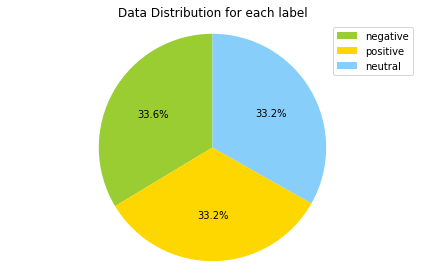

In [9]:
### Pie chart showing the class distribution in data

import matplotlib.pyplot as plt
# The slices will be ordered and plotted counter-clockwise.
labels = list(df['sentiment'].unique())
sizes = list(df['sentiment'].value_counts())
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts,per = plt.pie(sizes, colors=colors, startangle=90,autopct='%0.1f%%')
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Data Distribution for each label')
plt.tight_layout()
plt.show()

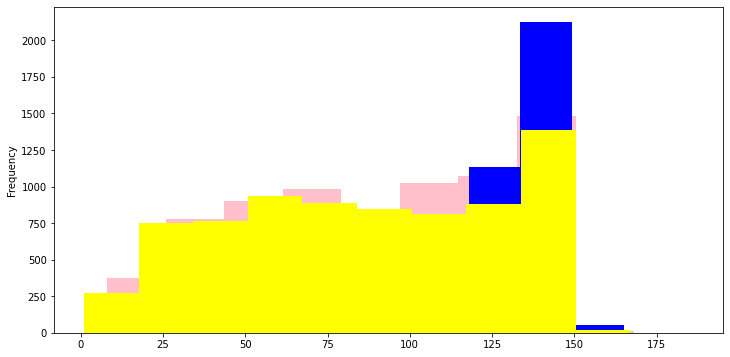

In [21]:
## Histogram showing the length of tweets of all categories
posdf['text'].str.len().plot.hist(color = 'pink', figsize = (12, 6))
negdf['text'].str.len().plot.hist(color = 'blue', figsize = (12, 6))
neudf['text'].str.len().plot.hist(color = 'yellow', figsize = (12, 6))

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english')
from wordcloud import WordCloud


Text(0.5, 1.0, 'WordCloud - Frequently Occuring Words in positive tweets')

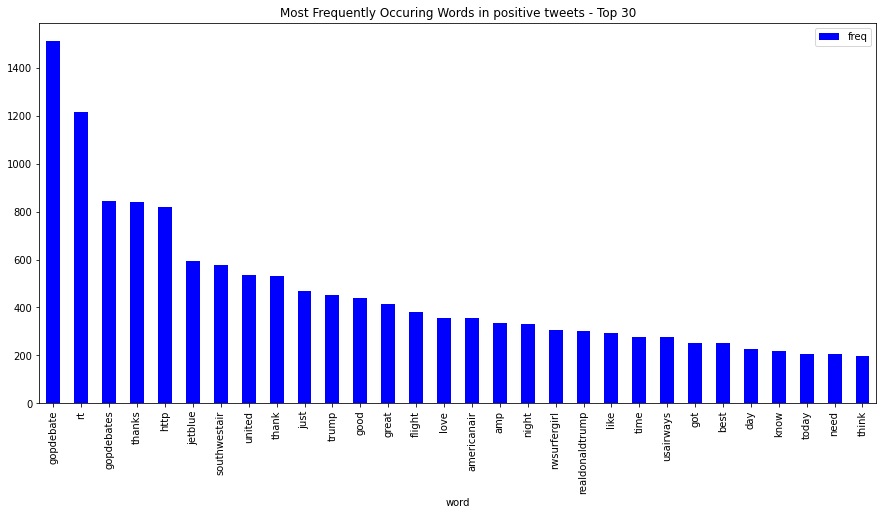

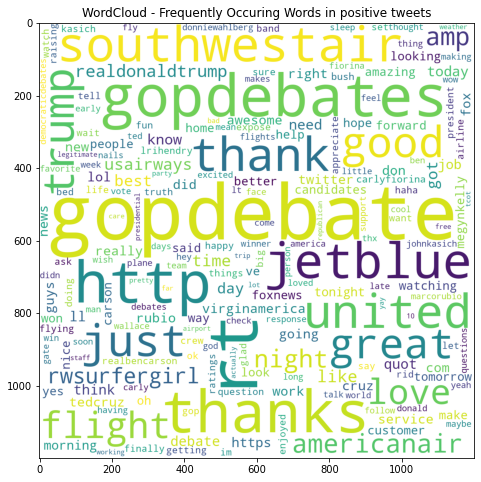

In [26]:

words = cv.fit_transform(posdf.text)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words in positive tweets - Top 30")


wordcloud = WordCloud(background_color = 'white', width = 1200, height = 1200).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Frequently Occuring Words in positive tweets", fontsize = 12)

Text(0.5, 1.0, 'Frequently Occuring Words in negative tweets')

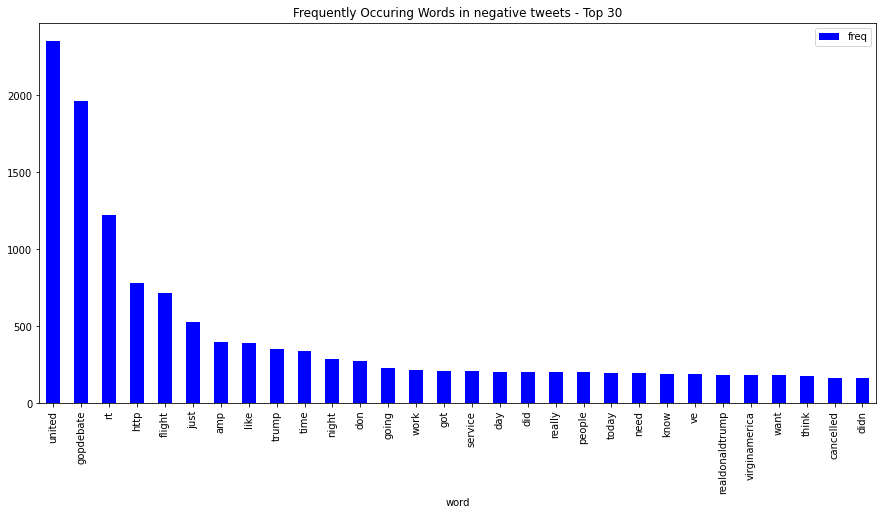

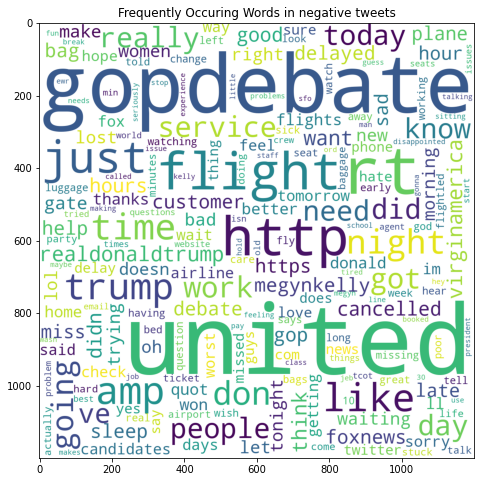

In [27]:

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(negdf.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Frequently Occuring Words in negative tweets - Top 30")


wordcloud = WordCloud(background_color = 'white', width = 1200, height = 1200).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("Frequently Occuring Words in negative tweets", fontsize = 12)

Text(0.5, 1.0, 'WordCloud - Frequently Occuring Words in neutral tweets')

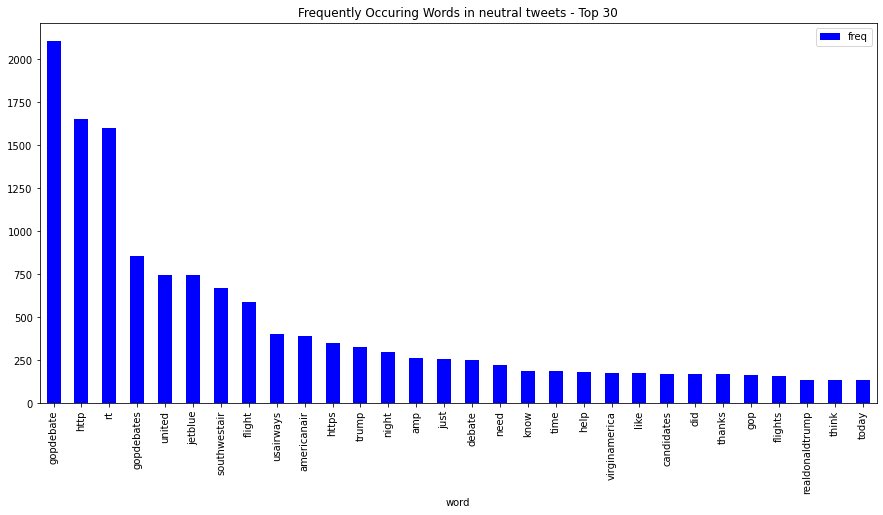

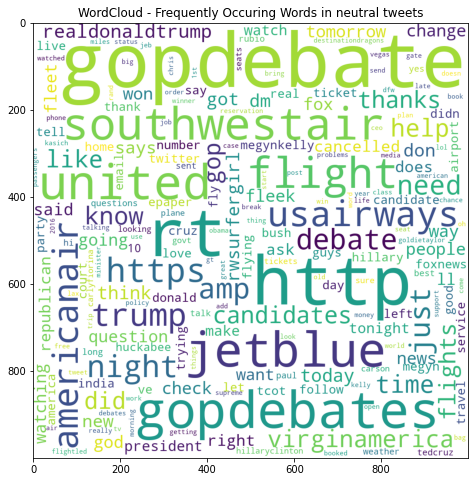

In [28]:


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(neudf.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Frequently Occuring Words in neutral tweets - Top 30")


wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Frequently Occuring Words in neutral tweets", fontsize = 12)

## 3. Data preprocessing:

In [83]:
import re, nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import joblib as joblib
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import pandas as pd


In [84]:
df=pd.read_csv('finalfile.csv')
df['sentiment'] = df['sentiment'].map({'negative' : 1 , "positive" :2 , "neutral":0})
from nltk.stem.porter import PorterStemmer

from sklearn.utils import shuffle
df = shuffle(df)


In [85]:

def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def preprocess_tweet(tweet,use_stemmer=False):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            processed_tweet.append(word)

    return ' '.join(processed_tweet)


def preprocess_csv(lines,use_stemmer=False):
    total = len(lines)
    pre_processed=[]
    for i in range(total):
        pre_processed.append(preprocess_tweet(lines[i]))
        
    return pre_processed


## 4. Training ,comparing the models performance :

In [86]:

def Cross_validation(data, targets, tfidf, clf_cv, model_name): #### Performs cross-validation on SVC

 

    kf = KFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
    scores=[]
    data_train_list = []
    targets_train_list = []
    data_test_list = []
    targets_test_list = []
    iteration = 0
    print("Performing cross-validation for {}...".format(model_name))
    for train_index, test_index in kf.split(data):
        iteration += 1
        print("Iteration ", iteration)
        data_train_cv, targets_train_cv = data.iloc[train_index], targets.iloc[train_index]
        data_test_cv, targets_test_cv = data.iloc[test_index], targets.iloc[test_index]
        data_train_list.append(data_train_cv) # appending training data for each iteration
        data_test_list.append(data_test_cv) # appending test data for each iteration
        targets_train_list.append(targets_train_cv) # appending training targets for each iteration
        targets_test_list.append(targets_test_cv) # appending test targets for each iteration
        tfidf.fit(data_train_cv) # learning vocabulary of training set
        data_train_tfidf_cv = tfidf.transform(data_train_cv)
        print("Shape of training data: ", data_train_tfidf_cv.shape)
        data_test_tfidf_cv = tfidf.transform(data_test_cv)
        print("Shape of test data: ", data_test_tfidf_cv.shape)
        clf_cv.fit(data_train_tfidf_cv.toarray(), targets_train_cv) # Fitting SVC
        score = clf_cv.score(data_test_tfidf_cv.toarray(), targets_test_cv) # Calculating accuracy
        scores.append(score) # appending cross-validation accuracy for each iteration
    print("List of cross-validation accuracies for {}: ".format(model_name), scores)
    mean_accuracy = np.mean(scores)
    print("Mean cross-validation accuracy for {}: ".format(model_name), mean_accuracy)
    print("Best cross-validation accuracy for {}: ".format(model_name), max(scores))
    max_acc_index = scores.index(max(scores)) # best cross-validation accuracy
    max_acc_data_train = data_train_list[max_acc_index] # training data corresponding to best cross-validation accuracy
    max_acc_data_test = data_test_list[max_acc_index] # test data corresponding to best cross-validation accuracy
    max_acc_targets_train = targets_train_list[max_acc_index] # training targets corresponding to best cross-validation accuracy
    max_acc_targets_test = targets_test_list[max_acc_index] # test targets corresponding to best cross-validation accuracy

 

    return mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,scores

 
def visualize_results(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, clf, model_name): #### Creates Confusion matrix for SVC
    tfidf.fit(max_acc_data_train)
    max_acc_data_train_tfidf = tfidf.transform(max_acc_data_train)
    max_acc_data_test_tfidf = tfidf.transform(max_acc_data_test)
    clf.fit(max_acc_data_train_tfidf, max_acc_targets_train) # Fitting SVC
    targets_pred = clf.predict(max_acc_data_test_tfidf) # Prediction on test data
    conf_mat = confusion_matrix(max_acc_targets_test, targets_pred)
    d={-1:'Negative', 0: 'Neutral', 1: 'Positive'}
    sentiment_df = targets.drop_duplicates().sort_values()
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=sentiment_df.values, yticklabels=sentiment_df.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix (Best Accuracy) - {}".format(model_name))
    plt.show()
    return


In [87]:
df['normalized']=preprocess_csv(df['text'].values)

Performing cross-validation for NBC...
Iteration  1
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  2
Shape of training data:  (20205, 1828)
Shape of test data:  (2245, 1828)
Iteration  3
Shape of training data:  (20205, 1811)
Shape of test data:  (2245, 1811)
Iteration  4
Shape of training data:  (20205, 1804)
Shape of test data:  (2245, 1804)
Iteration  5
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  6
Shape of training data:  (20205, 1824)
Shape of test data:  (2245, 1824)
Iteration  7
Shape of training data:  (20205, 1827)
Shape of test data:  (2245, 1827)
Iteration  8
Shape of training data:  (20205, 1815)
Shape of test data:  (2245, 1815)
Iteration  9
Shape of training data:  (20205, 1822)
Shape of test data:  (2245, 1822)
Iteration  10
Shape of training data:  (20205, 1810)
Shape of test data:  (2245, 1810)
List of cross-validation accuracies for NBC:  [0.6285077951002227, 0.6503340757238307, 0.63741648106

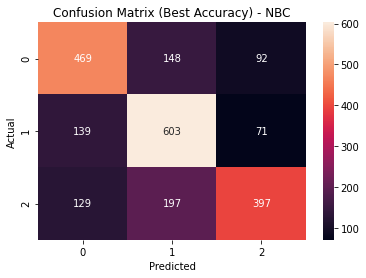

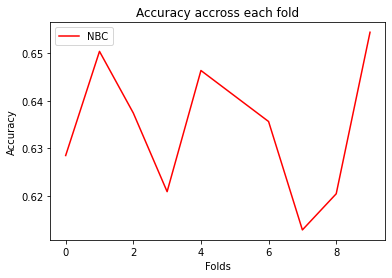

In [88]:
from sklearn.naive_bayes import MultinomialNB

data = df.normalized
targets = df.sentiment

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=30, norm='l2', ngram_range=(1,3)) # min_df=30 is a clever way of feature engineering

NBC_clf = MultinomialNB() # NBC Model
NBC_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,nbc_scores = Cross_validation(data, targets, tfidf, NBC_clf, "NBC") # NBC cross-validation
visualize_results(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, NBC_clf, "NBC") # NBC confusion matrix


## argument has accuracy values
plt.plot(nbc_scores,color='r',label="NBC")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1


Performing cross-validation for BernoulliNB...
Iteration  1
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  2
Shape of training data:  (20205, 1828)
Shape of test data:  (2245, 1828)
Iteration  3
Shape of training data:  (20205, 1811)
Shape of test data:  (2245, 1811)
Iteration  4
Shape of training data:  (20205, 1804)
Shape of test data:  (2245, 1804)
Iteration  5
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  6
Shape of training data:  (20205, 1824)
Shape of test data:  (2245, 1824)
Iteration  7
Shape of training data:  (20205, 1827)
Shape of test data:  (2245, 1827)
Iteration  8
Shape of training data:  (20205, 1815)
Shape of test data:  (2245, 1815)
Iteration  9
Shape of training data:  (20205, 1822)
Shape of test data:  (2245, 1822)
Iteration  10
Shape of training data:  (20205, 1810)
Shape of test data:  (2245, 1810)
List of cross-validation accuracies for BernoulliNB:  [0.6097995545657016, 0.628507795100222

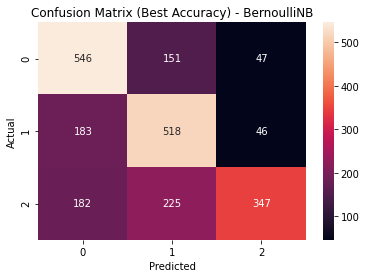

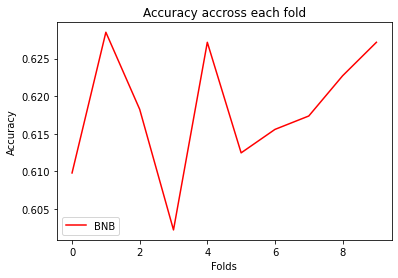

In [89]:
from sklearn.naive_bayes import BernoulliNB

B_clf = BernoulliNB() # NBC Model
BC_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,bnc_scores = Cross_validation(data, targets, tfidf, B_clf, "BernoulliNB") # NBC cross-validation
visualize_results(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, B_clf, "BernoulliNB") # NBC confusion matrix


## argument has accuracy values
plt.plot(bnc_scores,color='r',label="BNB")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1


Performing cross-validation for SVC...
Iteration  1
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  2
Shape of training data:  (20205, 1828)
Shape of test data:  (2245, 1828)
Iteration  3
Shape of training data:  (20205, 1811)
Shape of test data:  (2245, 1811)
Iteration  4
Shape of training data:  (20205, 1804)
Shape of test data:  (2245, 1804)
Iteration  5
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  6
Shape of training data:  (20205, 1824)
Shape of test data:  (2245, 1824)
Iteration  7
Shape of training data:  (20205, 1827)
Shape of test data:  (2245, 1827)
Iteration  8
Shape of training data:  (20205, 1815)
Shape of test data:  (2245, 1815)
Iteration  9
Shape of training data:  (20205, 1822)
Shape of test data:  (2245, 1822)
Iteration  10
Shape of training data:  (20205, 1810)
Shape of test data:  (2245, 1810)
List of cross-validation accuracies for SVC:  [0.6583518930957684, 0.6641425389755011, 0.66280623608

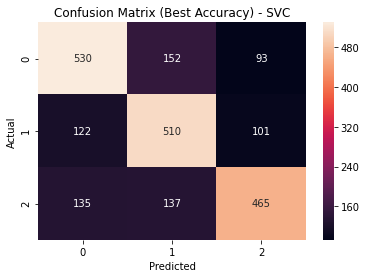

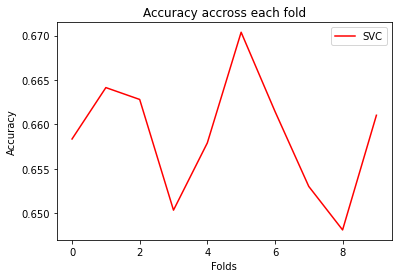

In [90]:
from sklearn.svm import LinearSVC

SVC_clf = LinearSVC() # SVC Model
SVC_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,svc_scores = Cross_validation(data, targets, tfidf, SVC_clf, "SVC") # SVC cross-validation
visualize_results(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, SVC_clf, "SVC") # NBC confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(svc_scores,color='r',label="SVC")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1


Performing cross-validation for LR...
Iteration  1
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  2
Shape of training data:  (20205, 1828)
Shape of test data:  (2245, 1828)
Iteration  3
Shape of training data:  (20205, 1811)
Shape of test data:  (2245, 1811)
Iteration  4
Shape of training data:  (20205, 1804)
Shape of test data:  (2245, 1804)
Iteration  5
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  6
Shape of training data:  (20205, 1824)
Shape of test data:  (2245, 1824)
Iteration  7
Shape of training data:  (20205, 1827)
Shape of test data:  (2245, 1827)
Iteration  8
Shape of training data:  (20205, 1815)
Shape of test data:  (2245, 1815)
Iteration  9
Shape of training data:  (20205, 1822)
Shape of test data:  (2245, 1822)
Iteration  10
Shape of training data:  (20205, 1810)
Shape of test data:  (2245, 1810)
List of cross-validation accuracies for LR:  [0.6610244988864142, 0.6717149220489977, 0.6757238307349

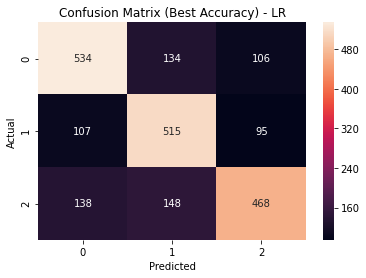

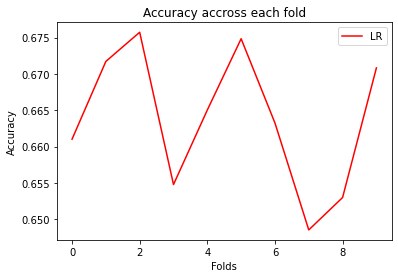

In [91]:
from sklearn.linear_model import LogisticRegression


LR_clf = LogisticRegression() # Logistic Regression Model
LR_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,lr_scores = Cross_validation(data, targets, tfidf, LR_clf, "LR") # cross-validation
visualize_results(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, LR_clf, "LR") # LR confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(lr_scores,color='r',label="LR")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1


Performing cross-validation for DT...
Iteration  1
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  2
Shape of training data:  (20205, 1828)
Shape of test data:  (2245, 1828)
Iteration  3
Shape of training data:  (20205, 1811)
Shape of test data:  (2245, 1811)
Iteration  4
Shape of training data:  (20205, 1804)
Shape of test data:  (2245, 1804)
Iteration  5
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  6
Shape of training data:  (20205, 1824)
Shape of test data:  (2245, 1824)
Iteration  7
Shape of training data:  (20205, 1827)
Shape of test data:  (2245, 1827)
Iteration  8
Shape of training data:  (20205, 1815)
Shape of test data:  (2245, 1815)
Iteration  9
Shape of training data:  (20205, 1822)
Shape of test data:  (2245, 1822)
Iteration  10
Shape of training data:  (20205, 1810)
Shape of test data:  (2245, 1810)
List of cross-validation accuracies for DT:  [0.557238307349666, 0.5474387527839644, 0.55545657015590

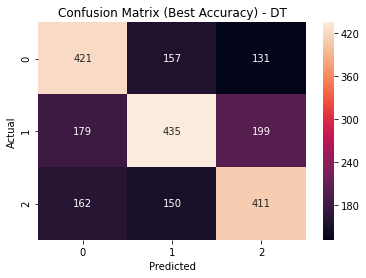

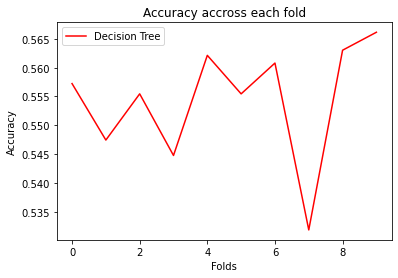

In [92]:
from sklearn.tree import DecisionTreeClassifier


DT_clf = DecisionTreeClassifier() # DT Regression Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = Cross_validation(data, targets, tfidf, DT_clf, "DT") # cross-validation
visualize_results(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, DT_clf, "DT") # LR confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(dt_scores,color='r',label="Decision Tree")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1


Performing cross-validation for RF...
Iteration  1
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  2
Shape of training data:  (20205, 1828)
Shape of test data:  (2245, 1828)
Iteration  3
Shape of training data:  (20205, 1811)
Shape of test data:  (2245, 1811)
Iteration  4
Shape of training data:  (20205, 1804)
Shape of test data:  (2245, 1804)
Iteration  5
Shape of training data:  (20205, 1820)
Shape of test data:  (2245, 1820)
Iteration  6
Shape of training data:  (20205, 1824)
Shape of test data:  (2245, 1824)
Iteration  7
Shape of training data:  (20205, 1827)
Shape of test data:  (2245, 1827)
Iteration  8
Shape of training data:  (20205, 1815)
Shape of test data:  (2245, 1815)
Iteration  9
Shape of training data:  (20205, 1822)
Shape of test data:  (2245, 1822)
Iteration  10
Shape of training data:  (20205, 1810)
Shape of test data:  (2245, 1810)
List of cross-validation accuracies for RF:  [0.6075723830734967, 0.6227171492204899, 0.6155902004454

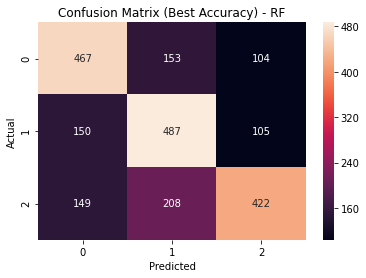

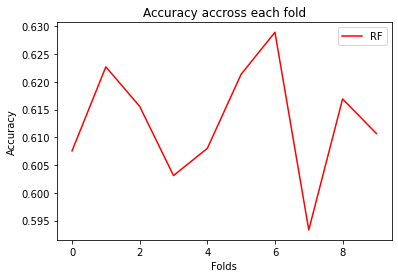

In [93]:
from sklearn.ensemble import RandomForestClassifier


RF_clf = RandomForestClassifier() # RF Model
RF_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,rf_scores = Cross_validation(data, targets, tfidf, RF_clf, "RF") # cross-validation
visualize_results(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, RF_clf, "RF") # RF confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(rf_scores,color='r',label="RF")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1


#### PLOT COMPARISON OF EACH CLASSIFIER

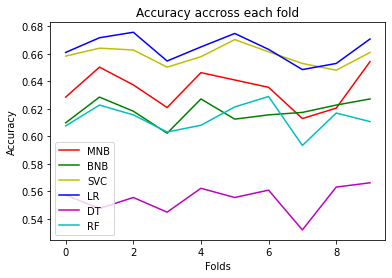

In [110]:

## argument has accuracy values
plt.plot(nbc_scores,color='r',label="MNB")
plt.plot(bnc_scores,color='g',label="BNB")
plt.plot(svc_scores,color='y',label="SVC")
plt.plot(lr_scores,color='b',label="LR")
plt.plot(dt_scores,color='m',label="DT")
plt.plot(rf_scores,color='c',label="RF")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1


## 5. Fine tuning and saving the model:

In [111]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [139]:
X_train, X_test, y_train, y_test = train_test_split(tfidf.fit_transform(data), targets, test_size=0.1, random_state=101)

## Hyper-parametertuning
param_distributions = { "alpha": uniform(1, 10), "fit_prior":[True,False]}
rnd_search_cv = RandomizedSearchCV(NBC_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] alpha=6.232185789059745, fit_prior=True .........................
[CV] .......... alpha=6.232185789059745, fit_prior=True, total=   0.0s
[CV] alpha=6.232185789059745, fit_prior=True .........................
[CV] .......... alpha=6.232185789059745, fit_prior=True, total=   0.0s
[CV] alpha=6.232185789059745, fit_prior=True .........................
[CV] .......... alpha=6.232185789059745, fit_prior=True, total=   0.0s
[CV] alpha=5.475510196852458, fit_prior=True .........................
[CV] .......... alpha=5.475510196852458, fit_prior=True, total=   0.0s
[CV] alpha=5.475510196852458, fit_prior=True .........................
[CV] .......... alpha=5.475510196852458, fit_prior=True, total=   0.0s
[CV] alpha=5.475510196852458, fit_prior=True .........................
[CV] .......... alpha=5.475510196852458, fit_prior=True, total=   0.0s
[CV] alpha=2.373346384364024, fit_prior=True .........................
[CV] .......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......... alpha=2.0438421888842617, fit_prior=True, total=   0.0s
[CV] alpha=2.0438421888842617, fit_prior=True ........................
[CV] ......... alpha=2.0438421888842617, fit_prior=True, total=   0.0s
[CV] alpha=7.10176918982277, fit_prior=False .........................
[CV] .......... alpha=7.10176918982277, fit_prior=False, total=   0.0s
[CV] alpha=7.10176918982277, fit_prior=False .........................
[CV] .......... alpha=7.10176918982277, fit_prior=False, total=   0.0s
[CV] alpha=7.10176918982277, fit_prior=False .........................
[CV] .......... alpha=7.10176918982277, fit_prior=False, total=   0.0s
[CV] alpha=4.442165990845947, fit_prior=False ........................
[CV] ......... alpha=4.442165990845947, fit_prior=False, total=   0.0s
[CV] alpha=4.442165990845947, fit_prior=False ........................
[CV] ......... alpha=4.442165990845947, fit_prior=False, total=   0.0s
[CV] alpha=4.442165990845947, fit_prior=False ........................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                           fit_prior=True),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA08814548>,
                                        'fit_prior': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [140]:
rnd_search_cv.best_estimator_

MultinomialNB(alpha=2.0438421888842617, class_prior=None, fit_prior=True)

In [142]:
rnd_search_cv.best_estimator_.fit(X_train, y_train)

MultinomialNB(alpha=2.0438421888842617, class_prior=None, fit_prior=True)

In [143]:
import pickle
# now you can save it to a file
with open('sentimentmodel.pkl', 'wb') as f:
    pickle.dump(rnd_search_cv.best_estimator_, f)

